# Restaurant analysis for Cities and Towns in Slovakia

## Introduction

In this project I am interested in restaurant market segmentation in all cities/towns in Slovakia. I am a fan of foreign cuisine. But unfortunatelly in my small home town (around 30 000 people) there is not much to offer. In this analysis i would like to find whether simmilar situation is the case for other towns as well.
This analysis could theoretically be helpfull for a starting restaurateur who does not know what cuisine should offer. Or for immigrant who want to share his/her native cousine, but don't know in which town to be most profitable. To be profitable, the owner should start a bussines in place with the higest possible average income of local population and also lowest possible crime rate, unemployment rate and poverty rate.

## Used data

For the current state of restaurant segmentation Foursquare API will be used. Instead of location data (in API LL) about latitude and longitude, parameter near will be used to get venues from whole town.
The source of demografic information as 
- Town population
- average wage 
- crime rate
- unemployment rate

will be found by Statistical Office of the Slovak Republic API. https://slovak.statistics.sk/

In [1]:
#Libraries export
import numpy as np
import pandas as pd
from matplotlib import pyplot
import requests
import folium
import json


#### Requesting population data

In [2]:
url='https://data.statistics.sk/api/v2/dataset/om7011rr/M,SK_CAP,SK0,SK01,SK010,SK0101,SK0102,SK0103,SK0104,SK0105,SK0106,SK0107,SK0108,SK02,SK021,SK0211,SK0212,SK0213,SK0214,SK0215,SK0216,SK0217,SK022,SK0221,SK0222,SK0223,SK0224,SK0225,SK0226,SK0227,SK0228,SK0229,SK023,SK0231,SK0232,SK0233,SK0234,SK0235,SK0236,SK0237,SK03,SK031,SK0311,SK0312,SK0313,SK0314,SK0315,SK0316,SK0317,SK0318,SK0319,SK031A,SK031B,SK032,SK0321,SK0322,SK0323,SK0324,SK0325,SK0326,SK0327,SK0328,SK0329,SK032A,SK032B,SK032C,SK032D,SK04,SK041,SK0411,SK0412,SK0413,SK0414,SK0415,SK0416,SK0417,SK0418,SK0419,SK041A,SK041B,SK041C,SK041D,SK042,SK0421,SK0422,SK0422_0425,SK0423,SK0424,SK0425,SK0426,SK0427,SK0428,SK0429,SK042A,SK042B,V/2019/IN010051?lang=en&type=json'
result=requests.get(url).json()
result

{'version': '2.0',
 'class': 'dataset',
 'label': 'Stock and Change of the Population-SR-Area-Reg-District, U-R',
 'update': '2021-03-21',
 'note': 'Data on population changes are obtained from statistical reports processing about demographic population events (marriages, divorces, births and deaths) producing statistical survey contents on population. The data cover all inhabitants residing permanently in Slovakia regardless of their citizenship as well as citizens of the SR with permanent residence in the SR during their temporary residence abroad. Demographic statistics includes also the statistics on spontaneous and induced abortions. Migration statistics includes internal migration (permanent address changes be-tween municipalities, or city parts in Bratislava and Košice) and foreign migration, which means a change of the country of residence, irrespective of citizenship.\nData from the Population and Housing Census make up the foundation for balancing of the number and structure 

At first I need to put information from JSON to DF. 

In [3]:
names=result['dimension']['om7011rr_vuc']['category']['label']
names_list=list(names.values())
population=result['value']
code=list(names.keys())
pop_df=pd.DataFrame(list(zip(names_list,population)),index=code,columns=['Territorial Unit', 'Population'])
pop_df.sort_values('Population',ascending=False).head(20)
pop_df.head(20)

,Territorial Unit,Population
M,City,2912062
SK_CAP,Bratislava (districts I - V),432864
SK0,Slovak Republic,5450421
SK01,Region of Bratislava (NUTS2),659598
SK010,Region of Bratislava,659598
SK0101,District of Bratislava I,41095
SK0102,District of Bratislava II,115653
SK0103,District of Bratislava III,67913
SK0104,District of Bratislava IV,97261
SK0105,District of Bratislava V,110942


This dataframe contanis information of how many people live in whole country, in regions, in district and also in cities/country areas. moreover cyties of Bratislava and Košice consist of multiple district and pop_df contain information of population sum for those cities. At first i will remove rows with whole country, City of Bratislava and Košice.


In [4]:
pop_df.drop(['SK_CAP','SK0422_0425'],inplace=True)

In [5]:
pop_df.drop(['SK0'],inplace=True)
pop_df

,Territorial Unit,Population
M,City,2912062
SK01,Region of Bratislava (NUTS2),659598
SK010,Region of Bratislava,659598
SK0101,District of Bratislava I,41095
SK0102,District of Bratislava II,115653
...,...,...
SK0428,District of Rožňava,62286
SK0429,District of Sobrance,22849
SK042A,District of Spišská Nová Ves,99652
SK042B,District of Trebišov,105411


The dataframe still contains an information about Cities and Country population sum. Those rows will be put to separate dataframe. Maybe, this info can provide interesting insights later.

In [6]:
CC_df=pop_df.loc[['M','V'],:]
CC_df

,Territorial Unit,Population
M,City,2912062
V,Country,2538359


The first territorial unit level is region. I will prepare DF for Regions based on following rule: The index of regions have string length equal to 5.

In [7]:
regions_df=pop_df[pop_df.index.str.len()==5].sort_values(by='Population',ascending=False)
regions_df['Territorial Unit']=[i.replace('Region of ','') for i in regions_df['Territorial Unit'] ]
regions_df=regions_df.rename(columns={'Population':'Region Pop.','Territorial Unit':'Region'})


In [8]:
regions_df

,Region,Region Pop.
SK041,Prešov,825022
SK042,Košice,800414
SK031,Žilina,691368
SK023,Nitra,676672
SK010,Bratislava,659598
SK032,Banská Bystrica,647874
SK022,Trenčín,585882
SK021,Trnava,563591


The same operation will be done for districts, where string length is 6

In [9]:
districts_df=pop_df[pop_df.index.str.len()==6].sort_values(by='Population',ascending=False)
districts_df['Territorial Unit']=[i.replace('District of ','') for i in districts_df['Territorial Unit'] ]
districts_df.rename(columns={'Territorial Unit':'District'}, inplace=True)
districts_df.rename(columns={'Population':'District Pop.'},inplace=True)

In [10]:
districts_df

,District,District Pop.
SK0417,Prešov,175038
SK0233,Nitra,161441
SK031B,Žilina,157807
SK0234,Nové Zámky,139432
SK0227,Prievidza,134238
...,...,...
SK0327,Poltár,21545
SK041B,Stropkov,20622
SK0322,Banská Štiavnica,16103
SK0319,Turčianske Teplice,15888


Next step is to extend created dataframes with average income, crime rate, unemployment and crime rate. Again Statistical Office of the Slovak Republic API will be used to make requests. The problem is that not every demographic ahave the same data structures.

### Unemployment data
Due to some strange reasons I dont understand, Again Statistical Office of the Slovak Republic API cannot provide unemployment data same way as population. Therfore, i will use tool caled DataCube to download csv format and upload it to dataframe.

In [11]:
un_csv = "Unemployment.csv"
unemployment_df=pd.read_csv(un_csv)
unemployment_df.set_index('Unnamed: 0',drop=True,inplace=True)
unemployment_df=unemployment_df[unemployment_df.index.str.contains("District")]
unemployment_df.index=[i.replace('District of ','') for i in unemployment_df.index ]
unemployment_df.index=[i.replace('?','',) for i in unemployment_df.index ]
unemployment_df=unemployment_df.reset_index().rename(columns={'index':'District'})
unemployment_df.replace({'Piešany':'Piešťany','Trenín':'Trenčín','Šaa':'Šaľa',
                         'Topoany':'Topoľčany','Byta':'Bytča',
                         'adca':'Čadca','Turianske Teplice':'Turčianske Teplice',
                         'Luenec':'Lučenec','Veký Krtíš':'Veľký Krtíš',
                        'Levoa':'Levoča','Stará ubova':'Stará Ľubovňa',
                         'Vranov nad Topou':'Vranou nad Topľou','Rožava':'Rožňava'},inplace=True)

In [12]:
unemployment_df

,District,Unemployment
0,Bratislava I,2.77
1,Bratislava II,3.22
2,Bratislava III,3.24
3,Bratislava IV,2.97
4,Bratislava V,2.00
...,...,...
74,Michalovce,8.40
75,Rožňava,12.14
76,Sobrance,11.35
77,Spišská Nová Ves,6.46


### Number of violent crimes and robberies
Like unemployment data, number of violent crimes and robberies (will be called only crimes from now) are downoaded by DATA cube not buy API.

In [13]:
crime_csv = "Crime.csv"
crime_df=pd.read_csv(crime_csv)
crime_df=crime_df[['Unnamed: 0','Crimes']]
crime_df.rename(columns={'Unnamed: 0':'Region', 'Crimes':'Crimes per Region'},inplace=True)
crime_df=crime_df[crime_df['Region'].str.contains('Region')]
crime_df['Region']=[i.replace('Region of ',"") for i in crime_df['Region']]
crime_df.drop(1,inplace=True)


In [14]:
crime_df

,Region,Crimes per Region
2,Bratislava,614
4,Trnava,555
5,Trenčín,549
6,Nitra,642
8,Žilina,761
9,Banská Bystrica,857
11,Prešov,643
12,Košice,904


unfortunatelly number of crimes is evaluated on regional level. Therefore, district level will be devided by number of inhabitants within district.

### Average Wage

In [15]:
url='https://data.statistics.sk/api/v2/dataset/np3110rr/SK_CAP,SK0,SK01,SK010,SK0101,SK0102,SK0103,SK0104,SK0105,SK0106,SK0107,SK0108,SK02,SK021,SK0211,SK0212,SK0213,SK0214,SK0215,SK0216,SK0217,SK022,SK0221,SK0222,SK0223,SK0224,SK0225,SK0226,SK0227,SK0228,SK0229,SK023,SK0231,SK0232,SK0233,SK0234,SK0235,SK0236,SK0237,SK03,SK031,SK0311,SK0312,SK0313,SK0314,SK0315,SK0316,SK0317,SK0318,SK0319,SK031A,SK031B,SK032,SK0321,SK0322,SK0323,SK0324,SK0325,SK0326,SK0327,SK0328,SK0329,SK032A,SK032B,SK032C,SK032D,SK04,SK041,SK0411,SK0412,SK0413,SK0414,SK0415,SK0416,SK0417,SK0418,SK0419,SK041A,SK041B,SK041C,SK041D,SK042,SK0421,SK0422,SK0422_0425,SK0423,SK0424,SK0425,SK0426,SK0427,SK0428,SK0429,SK042A,SK042B/2019/E_PRIEM_MZDA/3/SPOLU?lang=en&type=json'
result=requests.get(url).json()
result

{'version': '2.0',
 'class': 'dataset',
 'label': 'Wage by economic activity collected through workplace method',
 'update': '2020-08-20',
 'note': 'Data is surveyed for all enterprises and organizations with 20 and more employees, since 2010 irrespective of the number employees.\nSince 2009 data is surveyed from departmental quarterly survey on labour costs ISCP (Ministry of labour, social affairs and family) 1-04.\nData for fourth quarter - cumulative data for the entire year.Replaces the existing comprehensive survey of the annual statement of Praca 3-01.\nReplaces the existing comprehensive survey of the annual statement of Praca 3-01.\nNational data is including employees working abroad.\n',
 'href': 'http://datacube.statistics.sk/#!/view/en/VBD_SK_WIN/np3110rr/v_np3110rr_00_00_00_en',
 'id': ['nuts14',
  'np3110rr_rok',
  'np3110rr_ukaz',
  'np3110rr_dim1',
  'np3110rr_dim2',
  'np3110rr_data'],
 'size': [94, 1, 1, 1, 1, 1],
 'role': {'time': ['np3110rr_rok'],
  'geo': ['nuts14']

In [16]:
names=result['dimension']['nuts14']['category']['label']
names_list=list(names.values())
wage=result['value']
code=list(names.keys())
wage_df=pd.DataFrame(list(zip(names_list,wage)),index=code,columns=['District', 'Average Wage'])

wage_df=wage_df[wage_df['District'].str.contains('District')]
wage_df['District']=[i.replace('District of ',"") for i in wage_df['District']]
wage_df.head(20)

,District,Average Wage
SK0101,Bratislava I,1723.0
SK0102,Bratislava II,1760.0
SK0103,Bratislava III,1604.0
SK0104,Bratislava IV,1806.0
SK0105,Bratislava V,1592.0
SK0106,Malacky,1330.0
SK0107,Pezinok,1147.0
SK0108,Senec,1244.0
SK0211,Dunajská Streda,1078.0
SK0212,Galanta,1053.0


### Average household income per person

In [17]:
url='https://data.statistics.sk/api/v2/dataset/ps3001rr/SK0,SK01,SK010,SK02,SK021,SK022,SK023,SK03,SK031,SK032,SK04,SK041,SK042/2019/all?lang=en&type=json'
result=requests.get(url).json()


In [18]:
names=result['dimension']['nuts13']['category']['label']
names_list=list(names.values())
income=result['value']
code=list(names.keys())
income_df=pd.DataFrame(list(zip(names_list,income)),index=code,columns=['Region', 'Average Household Income per Person in region'])
income_df=income_df[income_df['Region'].str.contains('Region')]
income_df['Region']=[i.replace('Region of ',"") for i in income_df['Region']]
income_df=income_df.iloc[1:]

income_df


,Region,Average Household Income per Person in region
SK010,Bratislava,635.11
SK021,Trnava,517.08
SK022,Trenčín,513.92
SK023,Nitra,482.70
SK031,Žilina,456.99
SK032,Banská Bystrica,499.14
SK041,Prešov,425.18
SK042,Košice,466.06


### Cities/towns, district and region reference

Next step is to get data about population of cities / town and their relation to districts and regions. Data are scraped from wikipedia.

In [19]:
from bs4 import BeautifulSoup

In [20]:
#scraping
url='https://sk.wikipedia.org/wiki/Zoznam_miest_na_Slovensku'
response = requests.get(url)
soup = BeautifulSoup(response.content)
soup=soup.find("table").find('tbody')

In [21]:
#parsing to lists
texts=[]
nums=[]
for i in soup.find_all('td', align='left'):
    texts.append(i.text)
for i in soup.find_all('span', style='display:none'):
    nums.append(i.text)
nums=[float(i.rstrip()) for i in nums[3::4]]

city_list=[i.rstrip() for i in texts[::3]]
region_list=texts[1::3]
district_list=[i.rstrip() for i in texts[2::3]]

In [22]:
cities_df=pd.DataFrame(zip(city_list,region_list,district_list,nums),columns=['City / Town', 'Region', 'District','City Population'])
cities_df

,City / Town,Region,District,City Population
0,Bratislava,Bratislavský,"Bratislava I, II, III, IV, V",437725.0
1,Košice,Košický,"Košice I, II, III, IV",238593.0
2,Prešov,Prešovský,Prešov,88464.0
3,Žilina,Žilinský,Žilina,80727.0
4,Banská Bystrica,Banskobystrický,Banská Bystrica,78084.0
...,...,...,...,...
136,Podolínec,Prešovský,Stará Ľubovňa,3155.0
137,Rajecké Teplice,Žilinský,Žilina,3023.0
138,Spišská Stará Ves,Prešovský,Kežmarok,2230.0
139,Modrý Kameň,Banskobystrický,Veľký Krtíš,1624.0


In [23]:
#creation of dataframe
cities_df=pd.DataFrame(zip(city_list,region_list,district_list,nums),columns=['City / Town', 'Region', 'District','City Population'])
cities_df['Region'].replace({'Bratislavský':'Bratislava','Košický':'Košice','Prešovský':'Prešov',
                             'Žilinský':'Žilina','Banskobystrický':'Banská Bystrica',
                             'Nitriansky':'Nitra', 'Trnavský':'Trnava', 'Trenčiansky':'Trenčín'},inplace=True)
cities_df.replace({'Bratislava I, II, III, IV, V':'Bratislava','Košice I, II, III, IV':'Košice'},inplace=True)
#cities_df=pd.merge(cities_df,regions_merged,on='Region')
#cities_df=pd.merge(cities_df,districts_df,on='District')


Now all collected data about districts (population, Unemployment and wage )
                             and regions (population, crime and income)
will be moved to cities_df

In [24]:
regions_df.head()

,Region,Region Pop.
SK041,Prešov,825022
SK042,Košice,800414
SK031,Žilina,691368
SK023,Nitra,676672
SK010,Bratislava,659598


In [25]:
#Preparation of dataframe with all region information
regions_merged=pd.merge(pd.merge(regions_df,crime_df,on='Region'),income_df,on='Region')
regions_merged.head()


,Region,Region Pop.,Crimes per Region,Average Household Income per Person in region
0,Prešov,825022,643,425.18
1,Košice,800414,904,466.06
2,Žilina,691368,761,456.99
3,Nitra,676672,642,482.70
4,Bratislava,659598,614,635.11


In [26]:
#Preparation of dataframe with all district information
districts_merged=pd.merge(pd.merge(districts_df,unemployment_df,on='District'),wage_df,on='District')


In [27]:
districts_merged[districts_merged['District']=='Malacky']

,District,District Pop.,Unemployment,Average Wage
25,Malacky,73985,3.31,1330.0


Districts of Bratislava I, II, III, IV, V will be merged to only Bratislava. It is not administratively correct, but it is not so important for the purpose of this analyses. The same aproach is applied for districts of Košice I, II, III and IV.

In [28]:
bratislava_df=districts_merged[districts_merged['District'].str.contains('Bratislava')]
bratislava_un=(bratislava_df['District Pop.']*bratislava_df['Unemployment']).sum()/bratislava_df['District Pop.'].sum()
bratislava_pop=bratislava_df['District Pop.'].sum()
bratislava_AW=(bratislava_df['District Pop.']*bratislava_df['Average Wage']).sum()/bratislava_df['District Pop.'].sum()
kosice_df=districts_merged[districts_merged['District'].str.contains('Košice I')]
kosice_un=(kosice_df['District Pop.']*kosice_df['Unemployment']).sum()/kosice_df['District Pop.'].sum()
kosice_pop=kosice_df['District Pop.'].sum()
kosice_AW=(kosice_df['District Pop.']*kosice_df['Average Wage']).sum()/kosice_df['District Pop.'].sum()
bratislava=pd.DataFrame({'District':['Bratislava'],'District Pop.':[bratislava_pop],'Unemployment':[bratislava_un],'Average Wage':[bratislava_AW]},
                       )
kosice=pd.DataFrame({'District':['Košice'],'District Pop.':[kosice_pop],'Unemployment':[kosice_un],'Average Wage':[kosice_AW]},)
districts_merged=pd.concat([districts_merged,bratislava,kosice])
districts_merged=districts_merged[ ~districts_merged['District'].str.contains('Košice I')]
districts_merged=districts_merged[ ~districts_merged['District'].str.contains('Bratislava I')]
districts_merged=districts_merged[ ~districts_merged['District'].str.contains('Bratislava V')]
districts_merged.reset_index(drop=True,inplace=True)
districts_merged.head()


,District,District Pop.,Unemployment,Average Wage
0,Prešov,175038,5.60,1104.0
1,Nitra,161441,1.97,1201.0
2,Žilina,157807,3.46,1262.0
3,Nové Zámky,139432,2.73,1027.0
4,Prievidza,134238,4.70,1117.0


And now finally the merged dataframe for all information

In [29]:
cities_df=pd.merge(cities_df,districts_merged, on='District')
cities_df=pd.merge(cities_df,regions_merged, on='Region')
cities_df.head()

,City / Town,Region,District,City Population,District Pop.,Unemployment,Average Wage,Region Pop.,Crimes per Region,Average Household Income per Person in region
0,Bratislava,Bratislava,Bratislava,437725.0,432864,2.81156,1699.289955,659598,614,635.11
1,Pezinok,Bratislava,Pezinok,23034.0,64697,2.41000,1147.000000,659598,614,635.11
2,Modra,Bratislava,Pezinok,9046.0,64697,2.41000,1147.000000,659598,614,635.11
3,Svätý Jur,Bratislava,Pezinok,5724.0,64697,2.41000,1147.000000,659598,614,635.11
4,Senec,Bratislava,Senec,19963.0,88052,3.25000,1244.000000,659598,614,635.11


In [30]:
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 10 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   City / Town                                    129 non-null    object 
 1   Region                                         129 non-null    object 
 2   District                                       129 non-null    object 
 3   City Population                                129 non-null    float64
 4   District Pop.                                  129 non-null    int64  
 5   Unemployment                                   129 non-null    float64
 6   Average Wage                                   129 non-null    float64
 7   Region Pop.                                    129 non-null    int64  
 8   Crimes per Region                              129 non-null    object 
 9   Average Household Income per Person in region  129 non

Since Crimes per region are of object Dtype, it must be changed to int64.

In [31]:
cities_df['Crimes per Region']=cities_df['Crimes per Region'].astype('float64')


In [32]:
cities_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 10 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   City / Town                                    129 non-null    object 
 1   Region                                         129 non-null    object 
 2   District                                       129 non-null    object 
 3   City Population                                129 non-null    float64
 4   District Pop.                                  129 non-null    int64  
 5   Unemployment                                   129 non-null    float64
 6   Average Wage                                   129 non-null    float64
 7   Region Pop.                                    129 non-null    int64  
 8   Crimes per Region                              129 non-null    float64
 9   Average Household Income per Person in region  129 non

For better comprehension, All features will be renamed in order to contain information about relation to city, district or region.

In [33]:
cities_df.rename(columns={'Unemployment':'District Unemployment','Average Wage':'District Average Wage'},inplace=True)
cities_df.head()

,City / Town,Region,District,City Population,District Pop.,District Unemployment,District Average Wage,Region Pop.,Crimes per Region,Average Household Income per Person in region
0,Bratislava,Bratislava,Bratislava,437725.0,432864,2.81156,1699.289955,659598,614.0,635.11
1,Pezinok,Bratislava,Pezinok,23034.0,64697,2.41000,1147.000000,659598,614.0,635.11
2,Modra,Bratislava,Pezinok,9046.0,64697,2.41000,1147.000000,659598,614.0,635.11
3,Svätý Jur,Bratislava,Pezinok,5724.0,64697,2.41000,1147.000000,659598,614.0,635.11
4,Senec,Bratislava,Senec,19963.0,88052,3.25000,1244.000000,659598,614.0,635.11


Crimes per region shows total number of incidents. To increase the insight of the crime, it will be better to evaluate per 100 000 people.

In [34]:
cities_df['Crimes per 100k for Region']=cities_df['Crimes per Region']/cities_df['Region Pop.']*100000

## Using Foursquare API to download data about restaurants
For every city / town in the cities_df data about name of restaurant and restaurant type are downloaded. So API can return up to 100 results for city or all restaurants if it is less than 100. I guess not every restaurant is in the forsquare system. In the forsquare API i am not sending latitude and longitude information. City name is send instead.

In [35]:
CLIENT_ID = '1HSLXAN3NEVXHOAK45ETJQ5012KSY3UB4G50QVMLLD3ZUH3A' # your Foursquare ID
CLIENT_SECRET = '4Y1CK3DAQU31YPWHRYLWWMZND2BIKV1TIYZ3MJCUUTEZO5FL' # your Foursquare Secret
VERSION = '20210127' # Foursquare API version
ACCESS_TOKEN = 'OA2Z4SHGJIQQTFY4AQB5DROTH2OPYUZJO34FBQEGEAVYXQ2B'
LIMIT=1000


In [36]:
# Function for data obtaining
def get_data(city):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            city,             
            LIMIT,
            'food')
    results = requests.get(url).json()
    return results

#data are placed to lists
cities=[]
venues=[]
venue_types=[]
for city in cities_df['City / Town']:
    result=get_data(city)
    # if there is no result show the info
    if result['meta']['code']==400:
        print (city, 'cannot be found')
        continue
    
    for res in  result['response']['groups'][0]['items']:
        cities.append(city)
        venues.append(res['venue']['name'])
        venue_types.append(res['venue']['categories'][0]['name'])
        
# dataframe containg all information
restaurants_df=pd.DataFrame({'City':cities,'Name':venues,'Type':venue_types})


Šaštín-Stráže cannot be found
Sereď cannot be found


For two towns no result are found, therefore they will be removed from cities_df.

In [37]:
cities_df=cities_df[~cities_df['City / Town'].isin(['Šaštín-Stráže','Sereď'])]

now let's look at the restaurant categories.


In [38]:
pd.options.display.max_rows = 999
restaurants_df['Type'].value_counts().head(100)

Café                             484
Restaurant                       306
Pizza Place                      244
Eastern European Restaurant       98
Fast Food Restaurant              59
Italian Restaurant                50
Gastropub                         47
Burger Joint                      35
Bistro                            32
Slovak Restaurant                 32
Sushi Restaurant                  23
Asian Restaurant                  21
Chinese Restaurant                18
Steakhouse                        17
Bakery                            17
Vegetarian / Vegan Restaurant     16
Food                              15
Diner                             15
Vietnamese Restaurant             12
Sandwich Place                     9
Snack Place                        8
Modern European Restaurant         8
Doner Restaurant                   7
Comfort Food Restaurant            7
Creperie                           7
Indian Restaurant                  7
Kebab Restaurant                   7
G

In [39]:
pd.options.display.max_rows = 15

Many of found venues are in fact catgorized as Café which is not primary place to eat. I would like to focus on restaurants therefore i will remove them as well as Creperies, Bakeries ... 

In [40]:
out_of_focus=['Café','Bakery','Creperie','Pet Café','Food']

restaurants_df=restaurants_df[~restaurants_df['Type'].isin(out_of_focus)]

Since i am interested about specific cuisine types in restaurants, categories like "restaurant",  "food" or "bistro" cannot give specific information. Therefore all of these general categories will be renamed as "Other".

In [41]:
too_general=['Restaurant','Diner','Bistro','Buffet','Deli / Bodega']
mask=restaurants_df.Type.isin(too_general)
column_name='Type'
restaurants_df.loc[mask,column_name]="Other"
        
 

"Eastern European Restaurant" and "Slovak restaurant" are clearly the same categories. They will be merged as "Slovak restaurant".   

In [42]:
mask=restaurants_df.Type=='Eastern European Restaurant'
column_name='Type'
restaurants_df.loc[mask,column_name]="Slovak Restaurant"

restaurants_df2 contains the same as restaurants_df except of others

In [43]:
restaurants_df2=restaurants_df[restaurants_df['Type']!='Other']

types_df contain all information about how many restaurant can be assigned to certain category

In [44]:
types_df=pd.DataFrame(columns=restaurants_df2['Type'].value_counts().index)
for city in cities_df['City / Town']:    
    types_df.loc[city]=(restaurants_df2[restaurants_df2['City']==city]['Type'].value_counts())
types_df.replace(np.nan,0,inplace=True)

    

In [45]:
types_df.head()

,Pizza Place,Slovak Restaurant,Fast Food Restaurant,Italian Restaurant,Gastropub,Burger Joint,Sushi Restaurant,Asian Restaurant,Chinese Restaurant,Steakhouse,...,Tapas Restaurant,Dumpling Restaurant,German Restaurant,American Restaurant,Food Truck,South American Restaurant,Persian Restaurant,Taco Place,Salad Place,Hot Dog Joint
Bratislava,3.0,4.0,0.0,6.0,0.0,5.0,3.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
Pezinok,4.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Modra,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Svätý Jur,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Senec,2.0,3.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# for both cities_df and types_df the index must be the same
cities_df.set_index('City / Town',inplace=True)
types_df.index.name='City / Town'
cities_df.head()

,Region,District,City Population,District Pop.,District Unemployment,District Average Wage,Region Pop.,Crimes per Region,Average Household Income per Person in region,Crimes per 100k for Region
City / Town,,,,,,,,,,
Bratislava,Bratislava,Bratislava,437725.0,432864,2.81156,1699.289955,659598,614.0,635.11,93.087001
Pezinok,Bratislava,Pezinok,23034.0,64697,2.41000,1147.000000,659598,614.0,635.11,93.087001
Modra,Bratislava,Pezinok,9046.0,64697,2.41000,1147.000000,659598,614.0,635.11,93.087001
Svätý Jur,Bratislava,Pezinok,5724.0,64697,2.41000,1147.000000,659598,614.0,635.11,93.087001
Senec,Bratislava,Senec,19963.0,88052,3.25000,1244.000000,659598,614.0,635.11,93.087001


New columns will be added to cities_df with number of restaurants (including 'other category) and restaurants per capita to evaluate restaurant market satisfaction in particular city. 

In [47]:
cities_df['Restaurants']=restaurants_df['City'].value_counts()
cities_df['Restaurants per capita']=cities_df['Restaurants']/cities_df['City Population']

all_df will contain both information from cities_df and types_df. Moreover it is necessary to create category per capita columns.

In [48]:

all_df=cities_df.merge(types_df,on="City / Town")


In [49]:
names=['Pizza Place',
 'Slovak Restaurant',
 'Fast Food Restaurant',
 'Italian Restaurant',
 'Gastropub',
 'Burger Joint',
 'Sushi Restaurant',
 'Asian Restaurant',
 'Chinese Restaurant',
 'Steakhouse',
 'Vegetarian / Vegan Restaurant',
 'Vietnamese Restaurant',
 'Sandwich Place',
 'Modern European Restaurant',
 'Snack Place',
 'Doner Restaurant',
 'Indian Restaurant',
 'Comfort Food Restaurant',
 'Kebab Restaurant',
 'BBQ Joint',
 'Mediterranean Restaurant',
 'Greek Restaurant',
 'Japanese Restaurant',
 'Seafood Restaurant',
 'Cafeteria',
 'Turkish Restaurant',
 'Thai Restaurant',
 'Falafel Restaurant',
 'Food Court',
 'Czech Restaurant',
 'Breakfast Spot',
 'Hungarian Restaurant',
 'Middle Eastern Restaurant',
 'Soup Place',
 'Irish Pub',
 'Donut Shop',
 'French Restaurant',
 'Fried Chicken Joint',
 'Mexican Restaurant',
 'Fish & Chips Shop',
 'American Restaurant',
 'German Restaurant',
 'Indonesian Restaurant',
 'Tapas Restaurant',
 'Food Truck',
 'Israeli Restaurant',
 'Hot Dog Joint',
 'Taco Place',
 'Dumpling Restaurant',
 'South American Restaurant',
 'Persian Restaurant',
 'Salad Place']

In [50]:
#per capita categories
suffix='s per capita'
for i in names:    
    A=all_df[i]/all_df['City Population']
    #print(name)
    all_df[i+suffix]=A
all_df.head()

,Region,District,City Population,District Pop.,District Unemployment,District Average Wage,Region Pop.,Crimes per Region,Average Household Income per Person in region,Crimes per 100k for Region,...,Indonesian Restaurants per capita,Tapas Restaurants per capita,Food Trucks per capita,Israeli Restaurants per capita,Hot Dog Joints per capita,Taco Places per capita,Dumpling Restaurants per capita,South American Restaurants per capita,Persian Restaurants per capita,Salad Places per capita
City / Town,,,,,,,,,,,,,,,,,,,,,
Bratislava,Bratislava,Bratislava,437725.0,432864,2.81156,1699.289955,659598,614.0,635.11,93.087001,...,0.0,0.000002,0.000002,0.0,0.0,0.000002,0.0,0.0,0.000002,0.000002
Pezinok,Bratislava,Pezinok,23034.0,64697,2.41000,1147.000000,659598,614.0,635.11,93.087001,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
Modra,Bratislava,Pezinok,9046.0,64697,2.41000,1147.000000,659598,614.0,635.11,93.087001,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
Svätý Jur,Bratislava,Pezinok,5724.0,64697,2.41000,1147.000000,659598,614.0,635.11,93.087001,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
Senec,Bratislava,Senec,19963.0,88052,3.25000,1244.000000,659598,614.0,635.11,93.087001,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


## Main algorithm

The main idea how to decide where the specific cetegorie of restaurants should be opened is based on following points. Restaurant should be opened in town where there is:
    1) lowest ratio of restaurant per capita
    2) lowest ratio of restaurant specific category per capita
    3) lowest district unemployment
    4) highest district wage
    5) lowest region crime rate



In order to solve mentioned dilema, at first it is necessary to use MinMaxScaler to scale all categories from 0 to 1 where 0 is actual 0 value and 1 some theoretical maximum. For Unemployment it is historical maximum equal to 19.2 % (in year 2001), For crime rate it is maximum from last 10 years equal to 129.56 violent and property crimes per 100K and for wage it is 0.9 kvartil from wage distribution equal to 1975 euro. In this case is not possible to use scaling from lowest value to highest value as 1, because many towns will be removed from consideration based on scaled value is 1 or zero.

In [51]:
max_values=pd.DataFrame({'District Unemployment':19.2,'Crimes per 100k for Region':1295.6,'District Average Wage':1975},index=['Max values'])
max_values

,District Unemployment,Crimes per 100k for Region,District Average Wage
Max values,19.2,1295.6,1975


In [52]:
from sklearn.preprocessing import MinMaxScaler
scaled_df=all_df.drop(['Region','District','City Population','District Pop.','Region Pop.','Crimes per Region','Restaurants']+names,axis=1)

zeros=pd.DataFrame(np.zeros(scaled_df.shape[1]),index=scaled_df.columns.to_list(),).T
# append zeroes
scaled_df=scaled_df.append(zeros)
# append maximal values
scaled_df=scaled_df.append(max_values)
scaled_arr=np.array(scaled_df)
# scaling
scaled_arr=MinMaxScaler(feature_range=(0, 1)).fit_transform(scaled_arr)

# Put scaled values back to dataframe
scaled_df=pd.DataFrame(scaled_arr,columns=scaled_df.columns.to_list(),index=scaled_df.index.to_list())

In [53]:
scaled_df

,District Unemployment,District Average Wage,Average Household Income per Person in region,Crimes per 100k for Region,Restaurants per capita,Pizza Places per capita,Slovak Restaurants per capita,Fast Food Restaurants per capita,Italian Restaurants per capita,Gastropubs per capita,...,Indonesian Restaurants per capita,Tapas Restaurants per capita,Food Trucks per capita,Israeli Restaurants per capita,Hot Dog Joints per capita,Taco Places per capita,Dumpling Restaurants per capita,South American Restaurants per capita,Persian Restaurants per capita,Salad Places per capita
Bratislava,0.146435,0.860400,1.000000,0.071849,0.033743,0.009360,0.006374,0.000000,0.035401,0.000000,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
Pezinok,0.125521,0.580759,1.000000,0.071849,0.146566,0.237157,0.030281,0.000000,0.112124,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Modra,0.125521,0.580759,1.000000,0.071849,0.163277,0.000000,0.077106,0.000000,0.000000,0.110795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Svätý Jur,0.125521,0.580759,1.000000,0.071849,0.221174,0.238586,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Senec,0.169271,0.629873,1.000000,0.071849,0.200822,0.136820,0.104819,0.517491,0.000000,0.100411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Púchov,0.156771,0.650127,0.809183,0.072325,0.012015,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Myjava,0.149479,0.539241,0.809183,0.072325,0.128279,0.355828,0.060578,0.224307,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brezová pod Bradlom,0.149479,0.539241,0.809183,0.072325,0.265520,0.859270,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
scaled_df.loc['Tisovec']

District Unemployment                            0.788542
District Average Wage                            0.480000
Average Household Income per Person in region    0.785911
Crimes per 100k for Region                       0.102098
Restaurants per capita                           0.206508
                                                   ...   
Taco Places per capita                           0.000000
Dumpling Restaurants per capita                  0.000000
South American Restaurants per capita            0.000000
Persian Restaurants per capita                   0.000000
Salad Places per capita                          0.000000
Name: Tisovec, Length: 57, dtype: float64

names2 is a list containing column names of scaled_df but only those for restaurant categories

In [55]:
names2=[i+suffix for i in names]

Main formua for optimalization is score=(1-District Unemployment) * District Average Wage * (1 - Crimes per 100k for Region) * (1 - Restaurants per capita) * (1 - Specific Restaurants per capita)
for every feature in the equation penalty factor is multiplied with the feature. The most appropriate town where to open specific restaurant is then the town with highest score.

In [56]:
un_penalty=0.5 #unemployment penalty
wage_penalty=0.5
income_penalty=0.5
crime_penalty=0.3
res_penalty=1 # restaurants per capita penalty
cat_penalty=1 # current category penalty
for rec in names2:
    #formula create series with highest score for all restaurant categories
    A =(1-scaled_df['District Unemployment'])*un_penalty*scaled_df['District Average Wage']*wage_penalty*(1-scaled_df['Crimes per 100k for Region'])*crime_penalty*(1-scaled_df['Restaurants per capita'])*res_penalty*(1-scaled_df[rec])*cat_penalty
    print(rec)
    print(A.sort_values(ascending=False).head(),A.idxmax(), )
    print('\n')

Pizza Places per capita
Bratislava              0.048936
Púchov                  0.037683
Stará Turá              0.036086
Nové Mesto nad Váhom    0.033475
Turany                  0.033207
dtype: float64 Bratislava


Slovak Restaurants per capita
Bratislava              0.049083
Púchov                  0.037683
Trnava                  0.036193
Stará Turá              0.036086
Nové Mesto nad Váhom    0.035919
dtype: float64 Bratislava


Fast Food Restaurants per capita
Bratislava    0.049398
Púchov        0.037683
Stará Turá    0.036086
Nemšová       0.035357
Vráble        0.034187
dtype: float64 Bratislava


Italian Restaurants per capita
Bratislava              0.047649
Púchov                  0.037683
Stará Turá              0.036086
Hlohovec                0.036081
Nové Mesto nad Váhom    0.035919
dtype: float64 Bratislava


Gastropubs per capita
Bratislava              0.049398
Púchov                  0.037683
Stará Turá              0.036086
Hlohovec                0.036081
Nové M

## Results discussion
In last cells can be found top 5 results for every restaurant category. Unfortunatelly, we can see almost same towns in first five with highest score. In case of Bratislava it is quite obvious, because strongest feature in solved equation is restaurants per capita and Foursquare API can send only the results of 100 venues. Because Bratislava is by far most populated city in Slovakia it has always by far the best score for restaurant per capita. 

Following chart show the score for Pizza places as they are most frequent venue.

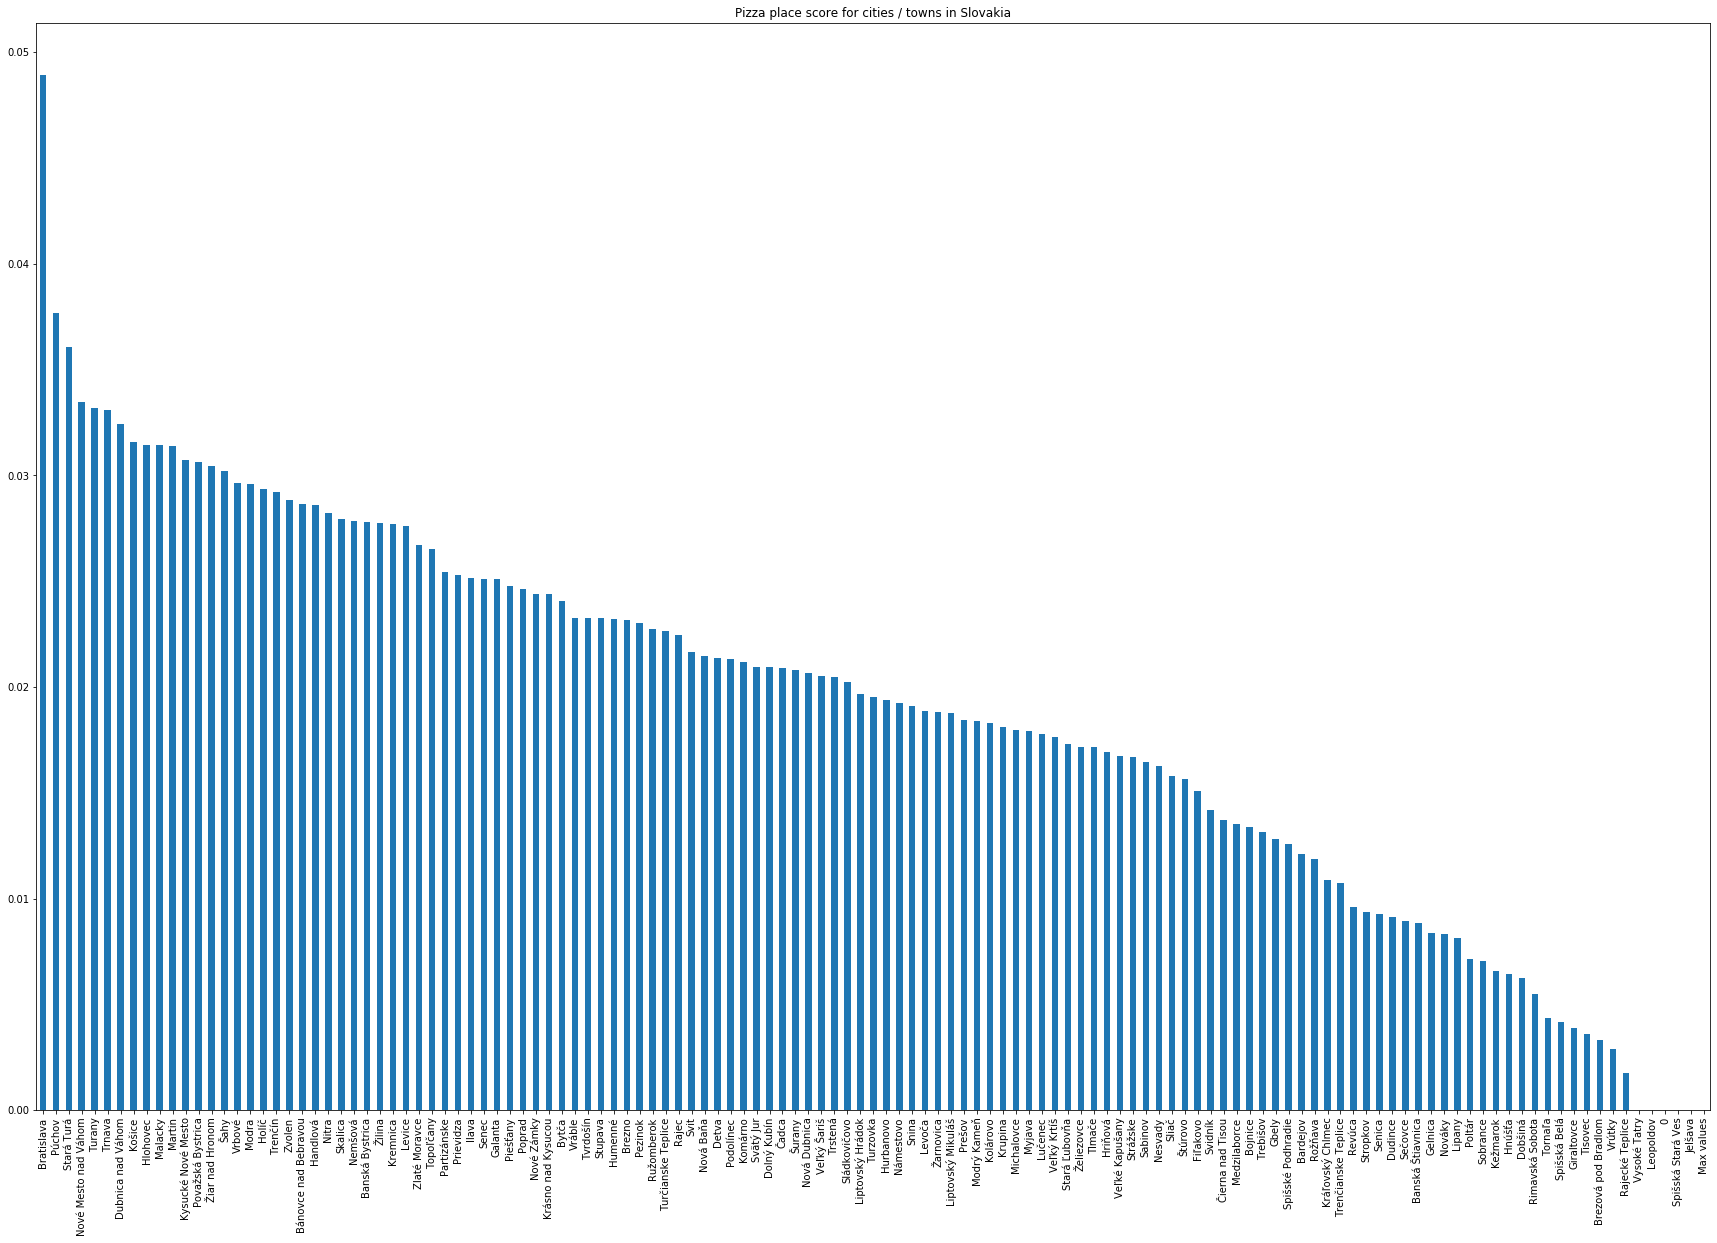

In [57]:
rec='Pizza Places per capita'
A =((1-scaled_df['District Unemployment'])*un_penalty*scaled_df['District Average Wage']*wage_penalty*(1-scaled_df['Crimes per 100k for Region'])*crime_penalty*(1-scaled_df['Restaurants per capita'])*res_penalty*(1-scaled_df[rec])*cat_penalty).sort_values(ascending=False)
A.plot(kind='bar',figsize=(30,20), title ='Pizza place score for cities / towns in Slovakia')

This type of analysis can obtain totaly different results when Penalties of main equation will be changed or if we will use different set of maximal values for scaling unemployment, crime and wage. By playng with those parameters it is possible to focus more on different preferenies as future restaurant owner. 